## Google Drive Connection

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
# To run the rest of the code you need to put this file in a folder named 'Labeling' in your 
# Google drive.
os.chdir('drive/My Drive/Colab Notebooks/Labeling')

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
from pathlib import Path
warnings.filterwarnings("ignore")

## Functions

In [46]:
def buy_and_hold(df, InitialCapital):
    '''
        Buy in first "BUY" label and sell on last "SELL" label
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    buy_index = df[df.Label == 1].index[0]
    sell_index = df[df.Label == 0].index[-1]
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        if i == buy_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif i == sell_index:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [47]:
# Implement Buy&Hold strategy
def buy_and_sell(df, InitialCapital):
    '''
    Update capital and number of shares after each buy or sell based on labels.

    Parameters
    ----------
        df : dataframe
            target dataframe for using buh&hold strategy
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after implementing buy&hold strategy on input dataframe
    """
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        
        if new_trend == 1 and capital != 0 and df.index[i] <= last_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif new_trend != old_trend and new_trend == 0:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [48]:
# Calculate rate of return
def ROR(df, InitialCapital):
    '''
    Calculate rate of return for each row that we have stock

    Parameters
    ----------
        df : dataframe
            dataframe for calculating ror
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after updating ROR values
    """
    '''

    df = df.assign(ROR=pd.Series(df.FinalCapital - InitialCapital)/ InitialCapital * 100)

    return df

In [49]:
# def DD(df):
#     pct = df[["Price"]].pct_change()
#     wealth_index = InitialCapital * (1 + pct["Price"]).cumprod()
#     previous_peaks = wealth_index.cummax()
#     drawdown = (wealth_index - previous_peaks) / previous_peaks
#     drawdown = list(abs(drawdown))
#     drawdown[0] = 0
#     df = df.assign(DD=pd.Series(drawdown))
#     return df

def DD(df):
    max_ror = max(df.ROR)
    DD_list = []
    for ror in df.ROR:
        DD_list.append(max_ror - ror)
    df = df.assign(DD=pd.Series(DD_list))
    return df

In [50]:
# Sharpe Ratio
# This should be changed
def sharpe_ratio(df):
    R = df.ROR[-1:].values[0]
    if df.ROR.std() == 0:
        return 0
    sr = R / df.ROR.std()
    return round(sr,2)

In [51]:
def metrics(df, InitialCapital, hold):
    if hold:
#        print('Buy and Hold:')
        df = buy_and_hold(df, InitialCapital)
    else:
#        print('Trading Strategy:')
        df = buy_and_sell(df, InitialCapital)
    df = ROR(df, InitialCapital)
    df = DD(df)
    MDD = round(max(abs(df.DD)),2)
    # Add RRR column
    df['RRR'] = (df['ROR'] / MDD) * 100

    sr = sharpe_ratio(df)
#    print(f"Sharpe Ratio = {sr} \n")
#    print(f"MDD = {MDD} \n")
    return df,sr, MDD

In [52]:
InitialCapital = 10e6
InitialCapital

10000000.0

### add_metrics()

In [53]:
def add_metrics(df, file_name, dataset_type = 'china', hold=False):
    date_col = 'Date'#DATE'
    close_col = 'Close' #'closingprice'
    if dataset_type == 'crypto':
        date_col = 'Date'
        close_col = 'Price'
    elif dataset_type == 'sp':
        date_col = '<DATE>'
        close_col = '<CLOSE>'
    data = {'Date': df[date_col], 'Price': df[close_col],
        'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
    df_new = pd.DataFrame(data)
    
    metrics_, sr, MDD = metrics(df_new, InitialCapital,hold)
    file_name_1 = file_name + '_metrics.csv'
    metrics_.to_csv(file_name_1)
    metrics_ = metrics_[metrics_['Number of Shares'] != '0'] 
    file_name_2 = file_name + '_metrics_filtered.csv'
    metrics_.to_csv(file_name_2)


    return metrics_, sr, MDD

# Trade Strategy Simulation

In [80]:
# Please put the desired stock name in the Stock variable.
# You need to Create a Folder named 'SR' under the folder you save the simulation results
# for the specific Stock code.
Stock = 'AMD'
DenoiseMethods = ['knn', 'ewm']
values = ['12', '20', '26', '50']
# beta indicates for 11 days or 44 days
beta=[True, False]
ClassificationMethods = ['lstm', 'gru','svm','xgboost', 'logreg']
# if hold is False then the trading strategy is Buy&Sell
hold = [False, True]

# The simulation process is only done for purging.
for DenoiseMethod in DenoiseMethods:
  for value in values:
    Name = Stock + DenoiseMethod + str(value)
    colnames = ['Stock', 'method_info', 'SR', 'MDD']
    Data = []
    for b in beta:
    #  print('-------------------- %s -----------------'%('11 days' if b else '44 days'))
      for method in ClassificationMethods:
    #  print('------------------ %s ------------------' %(method))
        for h in hold:
          if b:
            filename = 'Results/'+Stock+'/'+Name+('hold' if h else 'BS')+'_'+method+'_beta_p'
            df = pd.read_csv('Results/'+Stock+'/'+Name+'_'+method+'_beta_p.csv', index_col=None, header=0)
            method_info = method.upper() + '_' + DenoiseMethod.upper() + '_' + str(value) + ('hold' if h else 'B&S')
          else:
            filename = 'Results/'+Stock+'/'+Name+('hold' if h else 'BS')+'_'+method+'_p'
            df = pd.read_csv('Results/'+Stock+'/'+Name+'_'+method+'_p.csv', index_col=None, header=0)
            method_info = method.upper() + '_' + DenoiseMethod.upper() + '_beta_' + str(value) + ('hold' if h else 'B&S')
          metrics_, sr, MDD = add_metrics(df, file_name=filename , dataset_type='sp',hold=h)
          Data.append([Stock, method_info, sr, MDD])
    resultDF = pd.DataFrame(data = Data, columns=colnames)
    path = Path('Results/'+Stock+'/SR/'+Stock+'_sr_mdd.csv')
    if path.is_file():
      resultDF.to_csv(path, mode='a', index=False, header=False)
    else:
      resultDF.to_csv(path, index=False)

In [ ]:
# Cross
#df = pd.read_csv('Results/'+Stock+'/'+Name+'_logreg_beta.csv', index_col=None, header=0)
#add_metrics(df, 'Results/'+Stock+'/'+Name+'_logreg_beta', dataset_type='sp')

# Visualization

### Functions

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from dateutil import parser

In [16]:
def visualize_ror(df_dict, dataset_name, is_beta=False, is_purged=False, df_type='none'):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    if df_type == "sp":
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(str(date)))
    else:
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(date))
    
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        # print(df_dict[key].ROR)
        plt.plot(date_list, df_dict[key].ROR, label = method.upper())
    title = 'ROR on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()

In [17]:
def visualize_dd(df_dict, dataset_name, is_beta=False, is_purged = False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        print(df_dict[key].DD)
        plt.plot(date_list, df_dict[key].DD, label = method.upper())
    title = 'DD on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()


## RoR and MDD Plots

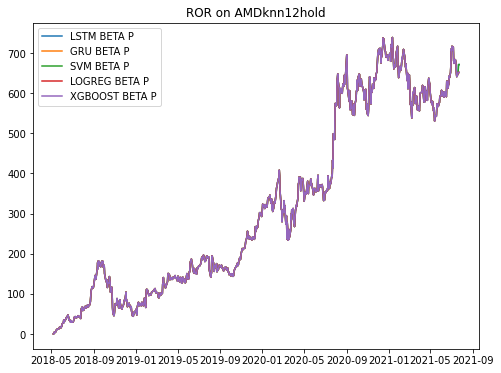

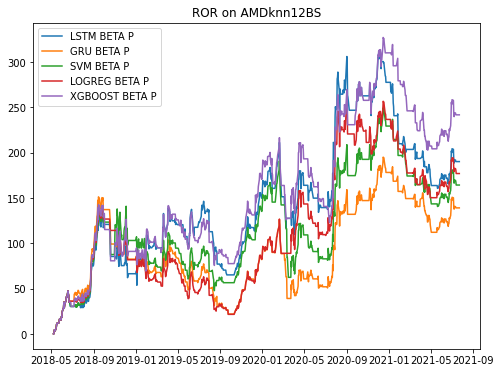

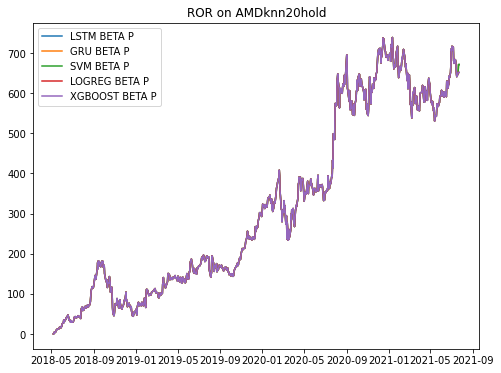

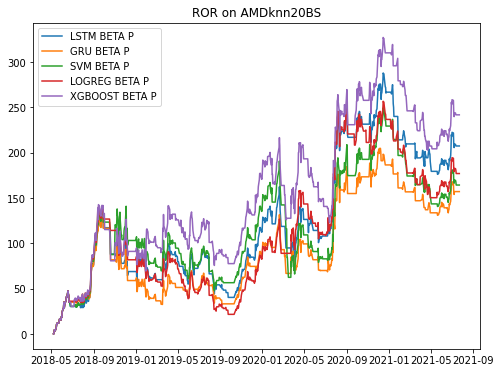

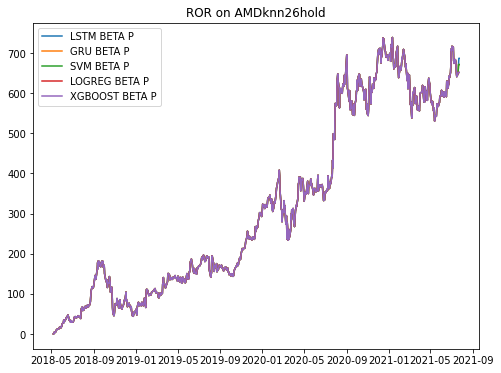

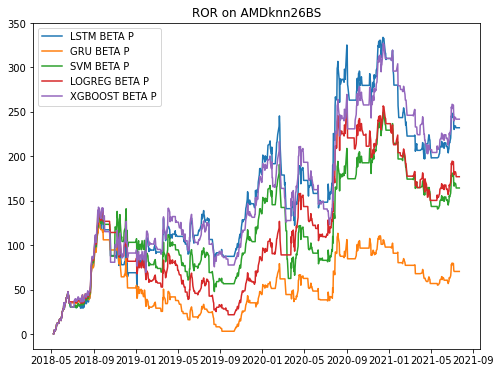

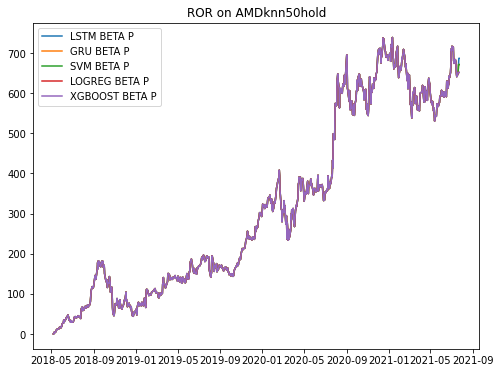

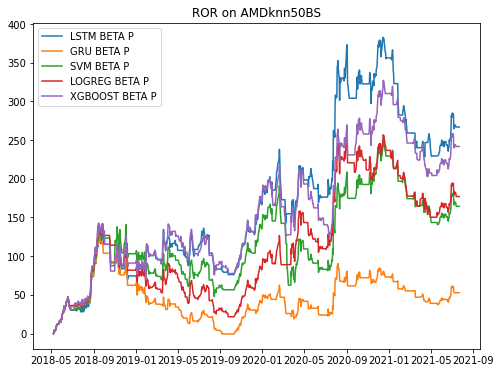

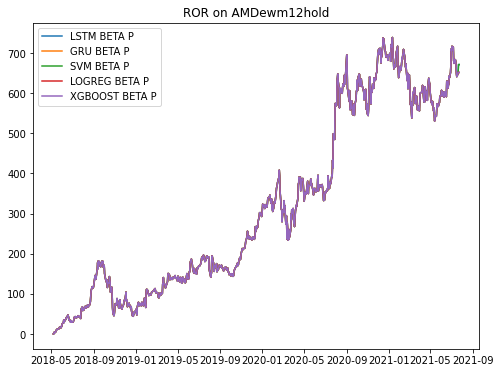

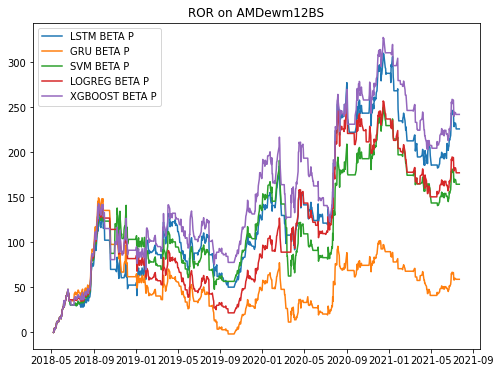

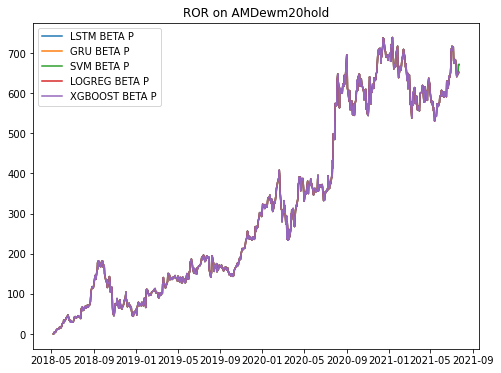

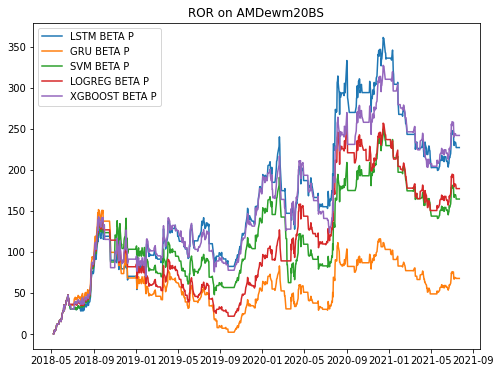

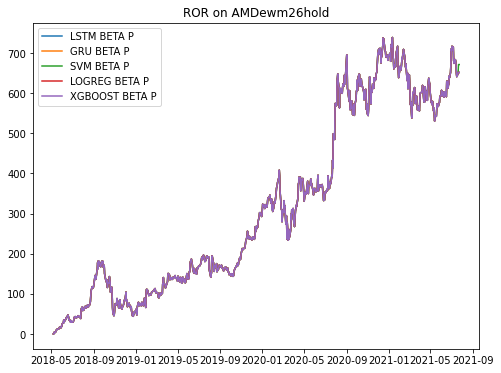

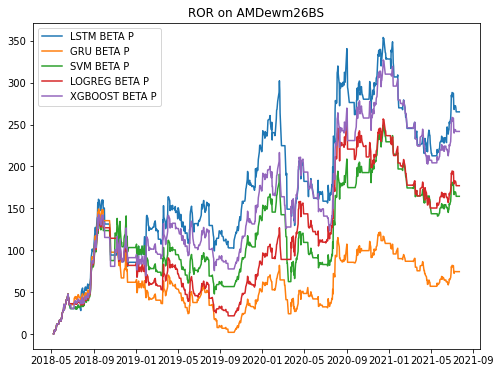

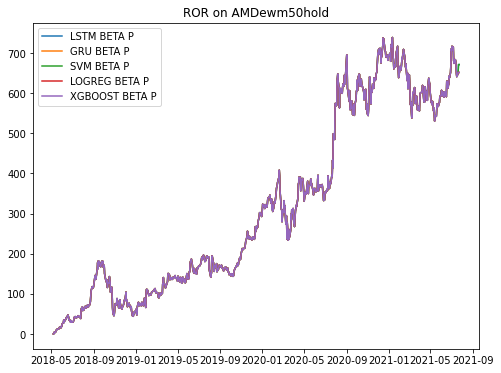

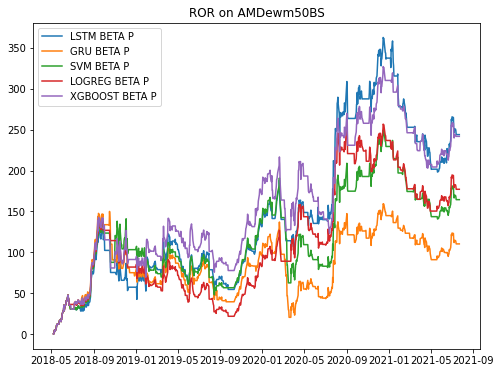

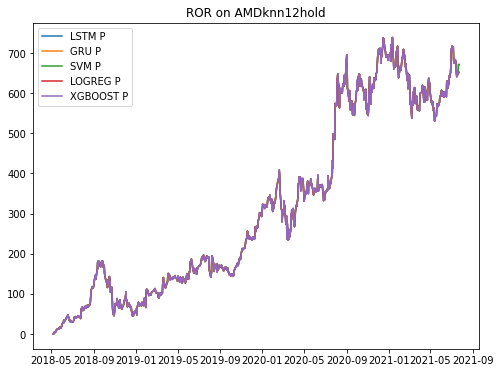

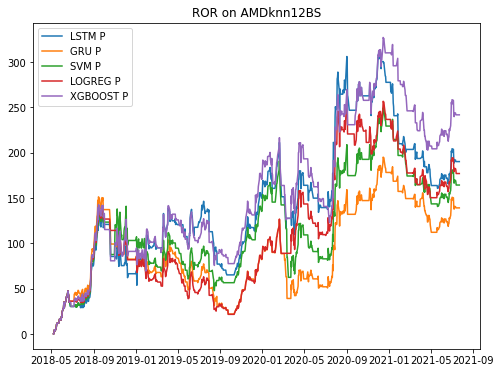

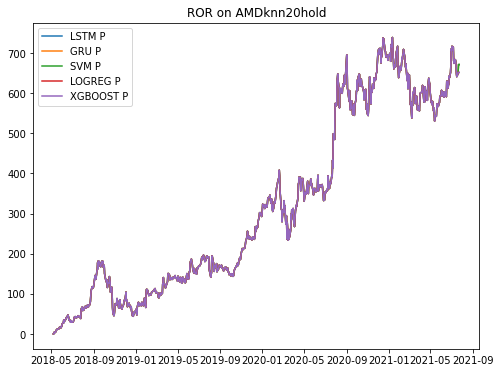

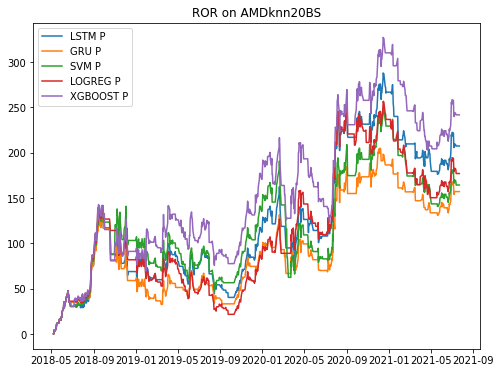

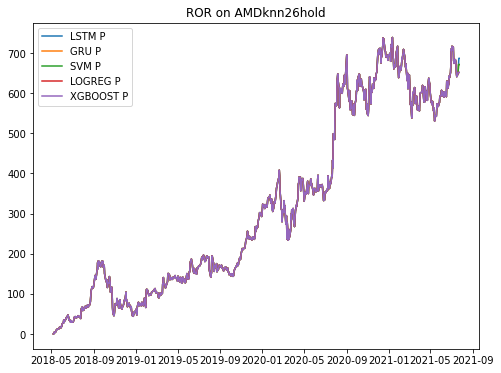

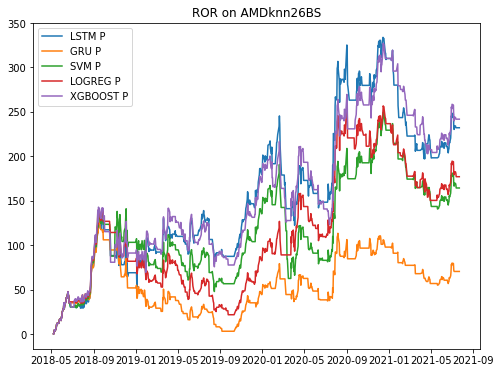

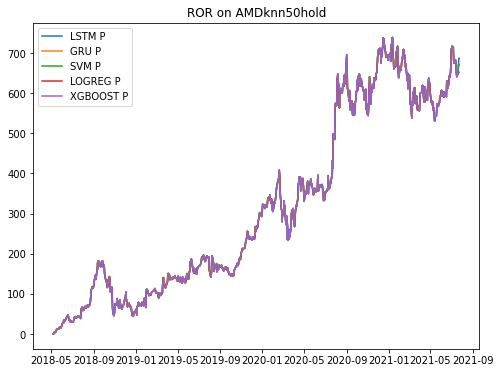

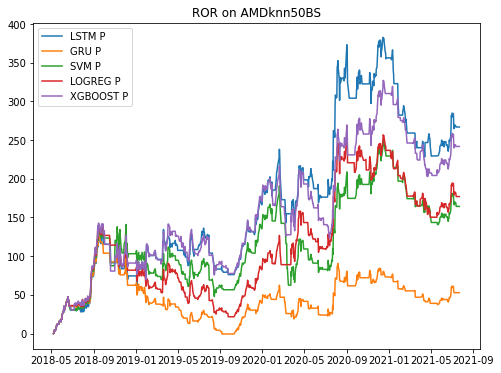

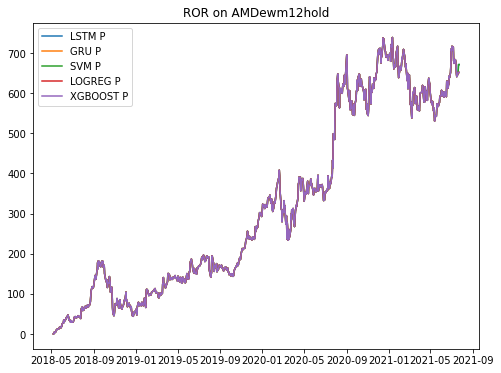

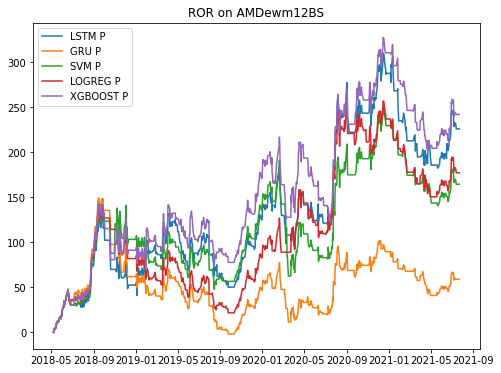

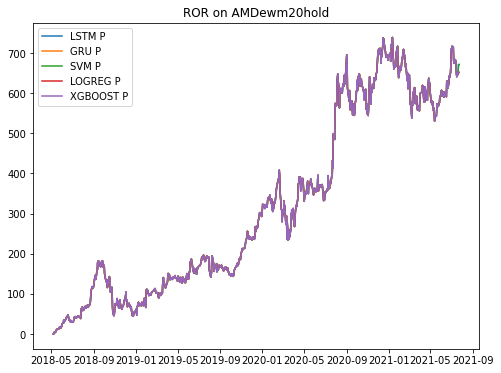

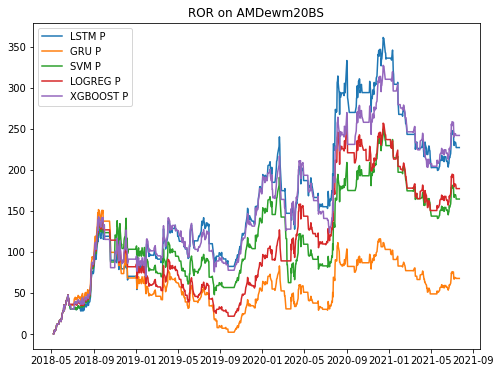

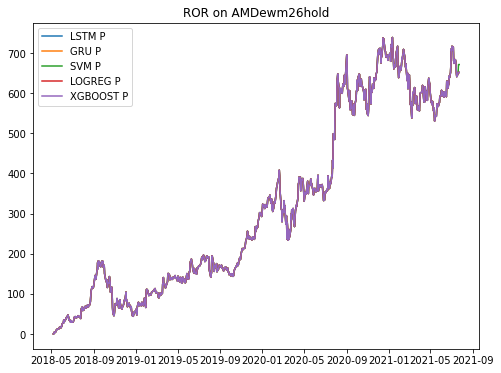

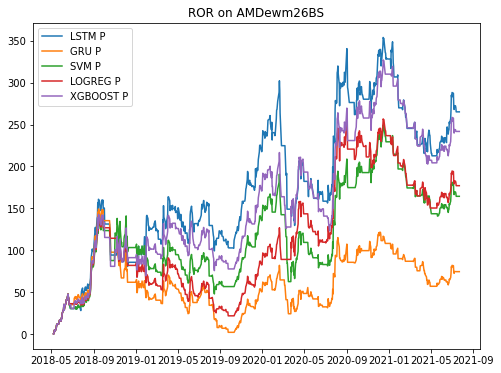

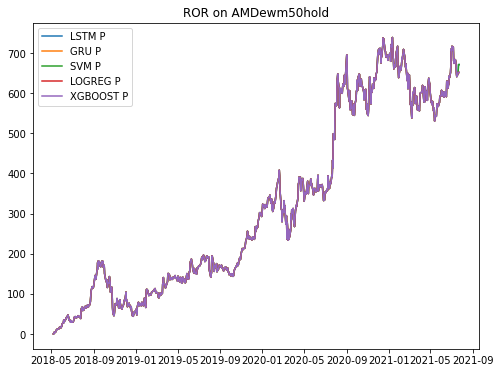

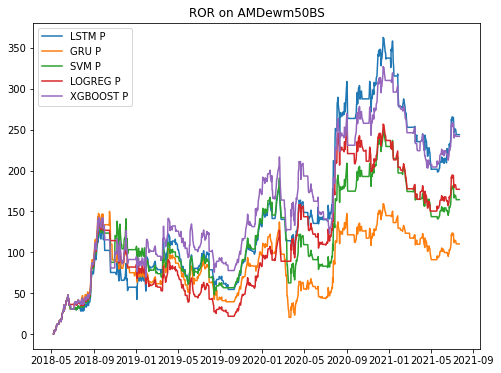

In [83]:
path = 'Results/' + Stock + '/*.csv' 
all_files = glob.glob(path)
df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df

startegy = ['hold', 'BS']
# The following section plots all ROR charts for all simulations available in the folder
# with the same name of the Stock under simulation. This folder can be found under the 
# 'Results' folder under the 'Labeling' parent folder.
for b in beta:
  for d in DenoiseMethods:
    for v in values:
      for s in startegy:
        Name = Stock + d + v + s
        visualize_ror(df_dict, dataset_name=Name, is_beta=b, is_purged=True, df_type='sp')